In [1]:
from pathlib import Path
from tqdm import tqdm
import sys

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("default")
WORK_DIR = Path().absolute()
RES_DIR = WORK_DIR / "results" / "bootstrap"
sys.path.append(str(WORK_DIR.parent))

In [2]:
from energyvslatconst import energyvslatconst, equilibrate_graphene

In [3]:
# DFT data
dft_data = np.loadtxt("../energyvslatconst/dft_data.txt", delimiter=",")

In [4]:
##########################################################################################
# Dropout
# -------

dropout_data = np.load(
    WORK_DIR.parent
    / "training_dropout"
    / "results"
    / "dropout"
    / "uncertainty_energy_vs_latconst.npz"
)
alist = dropout_data["alist"]
energy_mean_do = dropout_data["energy_mean"]
energy_error_do = dropout_data["energy_error"]

In [5]:
##########################################################################################
# Bootstrap
# ---------
# Compute the energy ensembles
preds_samples_file = RES_DIR / "uncertainty_energy_vs_latconst.npz"
if preds_samples_file.exists():
    preds_data = np.load(preds_samples_file)
    energy_ensembles = preds_data["energy_ensembles"]
else:
    energy_ensembles = np.empty((0, len(alist)))
    for set_idx in tqdm(range(100)):
        RES_DIR = WORK_DIR / "results" / "bootstrap" / f"{set_idx:03d}"
        modelname = f"DUNN_C_bootstrap_{set_idx:03d}"

        if (RES_DIR / f"DUNN_C_bootstrap_{set_idx:03d}").exists():
            _, elist, _ = energyvslatconst(modelname, alist, apply_dropout=False)
            energy_ensembles = np.row_stack((energy_ensembles, elist))
        else:
            continue
    energy_ensembles = energy_ensembles.astype(float)
    np.savez(preds_samples_file, alist=alist, energy_ensembles=energy_ensembles)

In [6]:
energy_mean_bs = np.mean(energy_ensembles, axis=0)
energy_error_bs = np.std(energy_ensembles, axis=0)

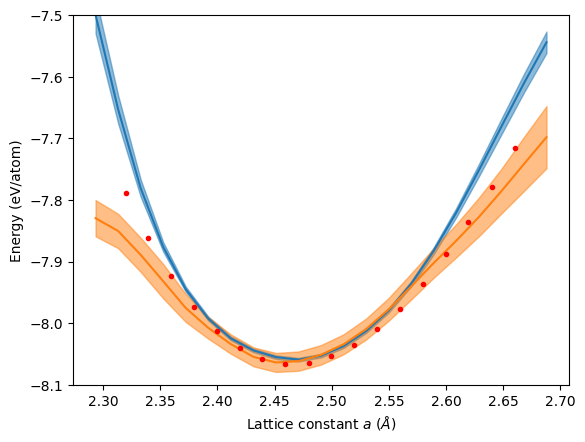

In [7]:
# Plot the result curves
# Energy vs lattice constant
plt.figure()
plt.plot(*(dft_data.T), "r.", zorder=10, label="DFT")

# Bootstrap
plt.fill_between(
    alist,
    energy_mean_bs - energy_error_bs,
    energy_mean_bs + energy_error_bs,
    alpha=0.5,
    color="tab:blue",
)
plt.plot(alist, energy_mean_bs, "-", color="tab:blue", label="DUNN bootstrap")

# Dropout
plt.fill_between(
    alist,
    energy_mean_do - energy_error_do,
    energy_mean_do + energy_error_do,
    alpha=0.5,
    color="tab:orange",
)
plt.plot(alist, energy_mean_do, "-", color="tab:orange", label="DUNN dropout")
plt.ylim(-8.1, -7.5)
plt.xlabel(r"Lattice constant $a$ $(\AA)$")
plt.ylabel("Energy (eV/atom)")
# plt.legend()

plt.show()
